In [ ]:
# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from workspace_utils import active_session

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.preprocessing import Imputer as Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [7]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',';')

In [8]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.shape


(891221, 85)

In [9]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [10]:
#
#                   Yikes.  With this many columns, I'm going to miss lots of data
#           or waste time scrolling back and forth.  Going to try to see
#           if the transpose() method works.  
#

pd.options.display.max_rows = 85
azdias.describe().transpose()




,count,mean,std,min,25%,50%,75%,max
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
ALTERSKATEGORIE_GROB,891221.0,2.777398,1.068775,1.0,2.0,3.0,4.0,9.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0
CJT_GESAMTTYP,886367.0,3.632838,1.595021,1.0,2.0,4.0,5.0,6.0
FINANZ_MINIMALIST,891221.0,3.074528,1.321055,1.0,2.0,3.0,4.0,5.0
FINANZ_SPARER,891221.0,2.821039,1.464749,1.0,1.0,3.0,4.0,5.0
FINANZ_VORSORGER,891221.0,3.401106,1.322134,1.0,3.0,3.0,5.0,5.0
FINANZ_ANLEGER,891221.0,3.033328,1.529603,1.0,2.0,3.0,5.0,5.0
FINANZ_UNAUFFAELLIGER,891221.0,2.874167,1.486731,1.0,2.0,3.0,4.0,5.0
FINANZ_HAUSBAUER,891221.0,3.075121,1.353248,1.0,2.0,3.0,4.0,5.0


In [11]:
#
#                   What good is the feat_info?  
#
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
rotgut = azdias.isna().sum().sum()
percent_miss = 100.0* (rotgut/(85.0*891221.0))
print("Raw number missing =  ",rotgut)
print("%age missing\t   = ","{:.6f}".format(percent_miss),"%");

#
#              Parse out list.  Looks like we need to remove the [] around the body.  
#       All right, maybe create a function and use pandas.apply.
#
print(feat_info['missing_or_unknown'])

Raw number missing =   4896838
%age missing	   =  6.464150 %
0       [-1,0]
1     [-1,0,9]
2       [-1,0]
3          [0]
4         [-1]
5         [-1]
6         [-1]
7         [-1]
8         [-1]
9         [-1]
10        [-1]
11         [0]
12          []
13          []
14      [-1,0]
15         [0]
16         [0]
17         [0]
18         [0]
19         [0]
20         [0]
21      [-1,0]
22      [-1,0]
23         [0]
24      [-1,9]
25      [-1,9]
26      [-1,9]
27      [-1,9]
28      [-1,9]
29      [-1,9]
30      [-1,9]
31      [-1,9]
32      [-1,9]
33      [-1,9]
34      [-1,9]
35      [-1,9]
36      [-1,9]
37      [-1,9]
38        [-1]
39        [-1]
40      [-1,0]
41        [-1]
42      [-1,9]
43         [0]
44          []
45          []
46      [-1,0]
47        [-1]
48      [-1,0]
49      [-1,0]
50         [0]
51          []
52      [-1,0]
53          []
54         [0]
55        [-1]
56        [-1]
57      [-1,X]
58        [XX]
59     [-1,XX]
60        [-1]
61        [-1]
62       

In [13]:
def parse_into_list(x):
    '''
    This function (I hope) will do the needed parse.  [] is an 
    empty list, etc.  
    
    Note:  This appraoch comes from Udacity Knowledge question
    https://knowledge.udacity.com/questions/334122!   
    '''
    new_list=[]
    # 
    x = x[1:-1].split(',')
    for i in x:
        try:
            new_list.append(int(i))
        except:
            new_list.append(i)
    return new_list

In [14]:
feat_info['index_NA'] = feat_info['missing_or_unknown'].apply(parse_into_list)

In [15]:
#
#                     This is to verify that the feat_info dataframe
#           has gotten a new column ['index_NA']
feat_info.head()

,attribute,information_level,type,missing_or_unknown,index_NA
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [16]:
#
#              Again using approach suggested in Udacity
#      knowledge question
att_index = feat_info.set_index('attribute')
na_azdias = azdias[:]

for column in na_azdias.columns:
    na_azdias[column].replace(att_index.loc[column].loc['index_NA'],np.NaN,inplace=True)
#
#                Now we again count the NaN entries.  There should be
#    more.
rotgut_new = na_azdias.isna().sum().sum()
percent_miss_new = 100.0* (rotgut_new/(85.0*891221.0))

print("More NA entries to the tune of  ", rotgut_new - rotgut)

print("Now, percentage missing\t    = ","{:.6f}".format(percent_miss_new),"%");

print("Total number of NaN entries\t", rotgut_new)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


More NA entries to the tune of   3477091
Now, percentage missing	    =  11.054139 %
Total number of NaN entries	 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
#
#                  Below ought to tell how many there are in each column---
#        except we can't see the entire amount.  If we set a pandas option
#        we can fix that. 
#
pd.options.display.max_rows = 85
na_azdias.isna().sum()



AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [18]:
# Investigate patterns in the amount of missing data in each column.
na_azdias_df = na_azdias.isna().sum().reset_index()
#
#                           Chose 75000, rather arbitraily, because the number of 
#             columns with that number or more of NAN entries seems to have some
#             kind of cutover there.
#
filter_view = na_azdias_df[na_azdias_df[0]>75000]



# Sorting by count of NA values
filter_view.sort_values(by=0,ascending=True,inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


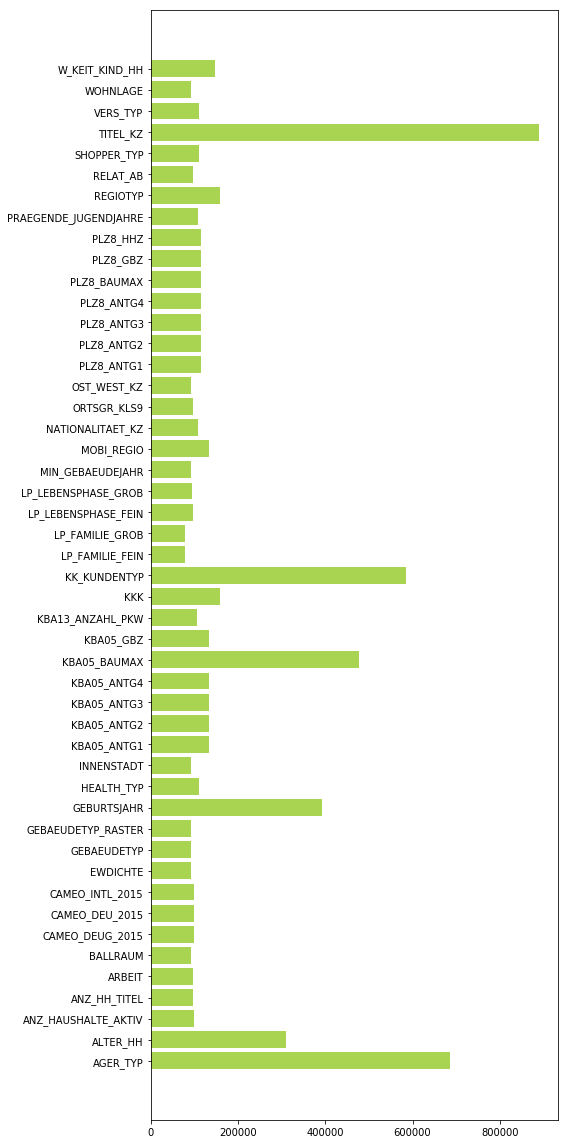

In [19]:
plt.figure(figsize=(8,16))
barh = plt.barh(filter_view['index'],filter_view[0],color = 'yellowgreen', alpha = 0.85)

plt.tight_layout()

In [20]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_columns = ['KBA05_BAUMAX','KK_KUNDENTYP','ALTER_HH','TITEL_KZ','GEBURTSJAHR','AGER_TYP']

na_azdias.drop(labels=outlier_columns,axis=1,inplace=True)


na_azdias.shape




/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

This area contains running notes as well as final discussion.
In the first place, 11.0% missing is kind of substantial.  Also, (see above) it looks like there is a divide right around 75000 enties missing;  47 columns(approx. count) are greater than that.  

Darn it!  Tried a sort for the plot which didn't work for some reason.  I can still pick out the weirdo columns, though, by eye.    Ignoring "ARBEIT", it looks in line with the others.   Same with "ORTSGR_KLS9". and several others.  

So, we get 4896838 entries missing/unknown to start with--pandas recognized these; total number of NaN entries 8373929 after I went through the suggested removal.  This is, over all rows and columns, a percentage missing of 11.054139%.

I found that the columns:  ['KBA05_BAUMAX','KK_KUNDENTYP','ALTER_HH','TITEL_KZ','GEBURTSJAHR','AGER_TYP']
were outliers in terms of having a much larger number of NaN entries than other (visually).  The removal of 6 columns gives new dataframe with 79 columns.  

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(array([ 96415.,  60529.,  12134.,   5139.,    480.,    155.,  14016.,
          5031.,  28038.,  46075.]),
 array([  1. ,   5.8,  10.6,  15.4,  20.2,  25. ,  29.8,  34.6,  39.4,
         44.2,  49. ]),
 <a list of 10 Patch objects>)

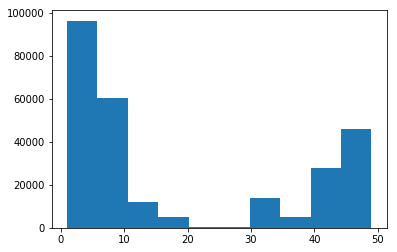

In [21]:
# How much data is missing in each row of the dataset?
#
#              Do a sum across the rows.  Then a histogram?
#
na_azdias['sum_na_row'] = na_azdias.isna().sum(axis=1)
plt.hist(na_azdias[na_azdias['sum_na_row']>0]['sum_na_row'],bins=10)



In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
#
#                  Looks like we get a division at 30. So ...
#
na_azdias_l30 = na_azdias[na_azdias['sum_na_row']<=30]
na_azdias_g30 = na_azdias[na_azdias['sum_na_row']>30]





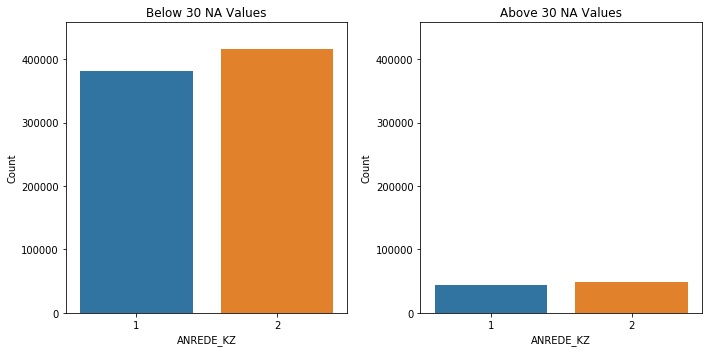

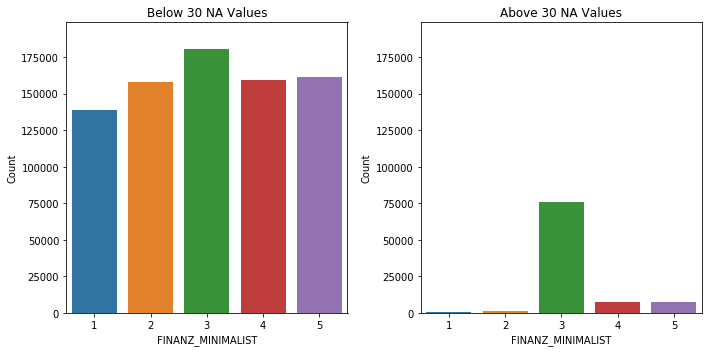

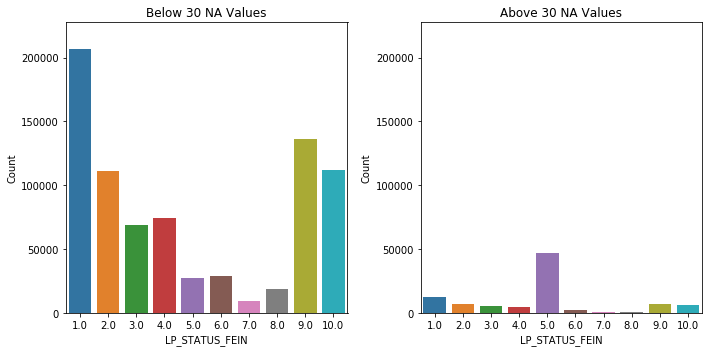

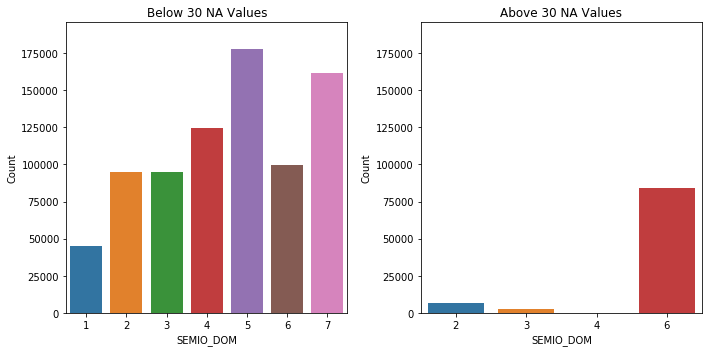

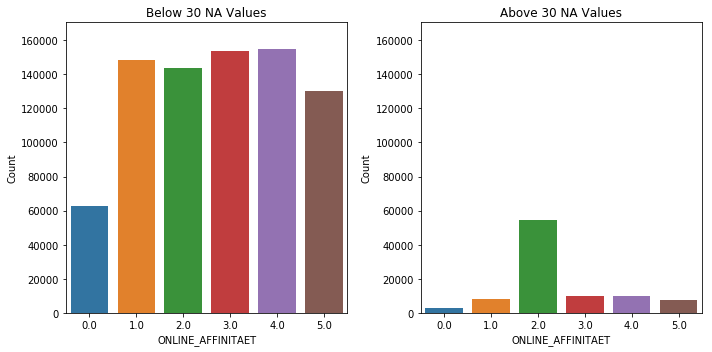

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.



def compare_columns(df1,df2,column,df1_title=None,df2_title=None):
    '''
    Takes two pandas dataframes and a column name as input and plots two 
    countplots of the given column for both dataframes.
    '''
    # Scale theem to the maximum --Think this will work
    df1_max = df1[column].value_counts().iloc[0]
    df2_max = df2[column].value_counts().iloc[0]
    if df1_max > df2_max:
        top = df1_max * 1.10
    else:
        top = df2_max * 1.10
    
    # Plotting
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    sns.countplot(df1[column],ax=ax1)
    ax1.set_ylabel('Count')
    ax1.set_ylim(top=top)
    ax1.set_title(df1_title)
    sns.countplot(df2[column],ax=ax2)
    ax2.set_ylabel('Count')
    ax2.set_ylim(top=top)
    ax2.set_title(df2_title)
    plt.tight_layout()
#
#          Call for each of the columns
#
for col in 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'LP_STATUS_FEIN', 'SEMIO_DOM', 'ONLINE_AFFINITAET':
    compare_columns(na_azdias_l30,na_azdias_g30,col,"Below 30 NA Values","Above 30 NA Values")

#### Discussion 1.1.3: Assess Missing Data in Each Row

Visually, the samples from the cases where there are less than 30 NA values and greater than or equal 
to 30 samples are strikingly different.  Since this difference exists, taking them out could introduce a bias.  Note also that in every case, though, the numbers for the >= 30 case are a lot smaller than for the < 30 case.  
Therefore, I believe any change (or bias) tyhat I put into the data set by ignoring the >= 30 will be small.  

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?
#

#
#                   Now we should be able to just use 'type' (?) 
#
feat_info = feat_info.set_index('attribute').drop(outlier_columns).reset_index()
feat_info['type'].value_counts()



ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
#
#           How to create a breakdown?  Start by creating a dictionary per each.
#      This is about my fifth cursed try! 
#
which_dtype = {}
dtypes = ['ordinal','categorical','numeric','mixed']
for iden in dtypes:
    which_dtype[iden]=feat_info[feat_info['type']==iden]['attribute']

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
def check_unique_vals(df):
    for col in df.columns:
        values = list(df[col].unique())
        print(str(col)+" : "+str(values))
print("\t\t  Size:  Under 30")
check_unique_vals(na_azdias_l30[which_dtype['categorical']])
print("\t\t  Size:  Over 30")
check_unique_vals(na_azdias_g30[which_dtype['categorical']])



		  Size:  Under 30
ANREDE_KZ : [2, 1]
CJT_GESAMTTYP : [5.0, 3.0, 2.0, 4.0, 1.0, 6.0, nan]
FINANZTYP : [1, 6, 5, 2, 4, 3]
GFK_URLAUBERTYP : [10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4.0, 2.0, 7.0, 6.0, nan]
GREEN_AVANTGARDE : [0, 1]
LP_FAMILIE_FEIN : [5.0, 1.0, nan, 10.0, 2.0, 7.0, 11.0, 8.0, 4.0, 6.0, 9.0, 3.0]
LP_FAMILIE_GROB : [3.0, 1.0, nan, 5.0, 2.0, 4.0]
LP_STATUS_FEIN : [2.0, 3.0, 9.0, 4.0, 1.0, 10.0, 5.0, 8.0, 6.0, 7.0, nan]
LP_STATUS_GROB : [1.0, 2.0, 4.0, 5.0, 3.0, nan]
NATIONALITAET_KZ : [1.0, 3.0, 2.0, nan]
SHOPPER_TYP : [3.0, 2.0, 1.0, 0.0, nan]
SOHO_KZ : [1.0, 0.0]
VERS_TYP : [2.0, 1.0, nan]
ZABEOTYP : [5, 3, 4, 1, 6, 2]
GEBAEUDETYP : [8.0, 1.0, 3.0, 2.0, 6.0, 4.0, 5.0]
OST_WEST_KZ : ['W', 'O']
CAMEO_DEUG_2015 : ['8', '4', '2', '6', '1', '9', '5', '7', nan, '3']
CAMEO_DEU_2015 : ['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C', '8B', '7A', '5D', '9E', nan, '9B', '1B', '3D', '4E', '4B', '3C', '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1

In [27]:
#
#                           Okay, we now have listings of wehich ones are which. 
#         For the "less than 30", looks like 13 columns are in that group.  
#
#
var_binary = []
var_multi = []
for var_ex in which_dtype['categorical']:
    if na_azdias_l30[var_ex].nunique() > 2:
        var_multi.append(var_ex)
    else:
        var_binary.append(var_ex)

In [28]:
var_multi

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [29]:
print(len(var_multi))

13


In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.
na_azdias_l30.loc[:, 'OST_WEST_KZ'].replace({'W':'0', 'O':'1'}, inplace=True)


# dropping the multilevel categorical columns
na_azdias_l30.drop(var_multi, axis=1, inplace=True)





/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Discussion 1.2.1: Re-Encode Categorical Features

So, okay, looks like "CAMEO_DEU_2015", "OST_WEST_KZ" are non-numeric.  The "OST_WEST_KZ" variable is clearly the one binary mentioned that takes non-numeric values and will need to be re-encoded.  

There look to be 13 categorical features which take on 3 or more values.  These include several family status features, shopper type and others.  If I drop these, will I have anything left that is useful?  But one-hot encoding all of them is going to be such a pain.  Maybne try dropping them and see if anything is left to do PCA on?  How to conveniently drop them?  Try a function which grabs them?  
Not sure about VERS_TYP, as it only has NaN as the third feature. 

Later--running out of time!  Going to just drop these beasts.  

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [31]:

na_azdias_l30[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
1,14.0
2,15.0
3,8.0
4,8.0
5,3.0


In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#
#                          From the data dictionary, the below makes some
#          kind of sense. 
#


def define_interval(x):
    if x in (1,2):
        return 1
    elif x in (3,4):
        return 2
    elif x in (5,6,7):
        return 3
    elif x in (8,9):
        return 4
    elif x in (10,11,12,13):
        return 5
    elif x in (14,15):
        return 6
    
def define_movement(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    elif x in (1,3,5,8,10,12,14):
        return 1
#
#         adding new columns "DECADES"  and 'MOVEMENTS' based on decade of birth and movement
#
na_azdias_l30['DECADES'] = na_azdias_l30['PRAEGENDE_JUGENDJAHRE'].apply(define_interval)
na_azdias_l30['MOVEMENTS'] = na_azdias_l30['PRAEGENDE_JUGENDJAHRE'].apply(define_movement)



#
#                       Have to drop the original column, else the problems of mixed data
#             show up!
#
na_azdias_l30 = na_azdias_l30.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
na_azdias_l30['DECADES'].value_counts().sort_index()

1.0     28157
2.0     74296
3.0    114354
4.0    175200
5.0    151770
6.0    225532
Name: DECADES, dtype: int64

In [34]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#
#                       From the data dictionary, looks like this variable is
#          a combinastion of "wealth" and "life stage".  So we create two like that.  
#


def cameo_wealth(x):
    if x // 10 ==1:
        return 1
    if x // 10 ==2:
        return 2
    if x // 10 ==3:
        return 3
    if x // 10 ==4:
        return 4
    if x // 10 ==5:
        return 5

def cameo_life_stage(x):
    if x % 10 ==1:
        return 1
    if x % 10 ==2:
        return 2
    if x % 10 ==3:
        return 3
    if x % 10 ==4:
        return 4
    if x % 10 ==5:
        return 5

#
#                   Now do the same thing we did for the other, that is apply 
#           those two functions, then drop the original.
#
#                   Damn!  Got traceback, need to convert to numeric first.  
#
    
na_azdias_l30['CAMEO_INTL_2015'] = pd.to_numeric(na_azdias_l30['CAMEO_INTL_2015'])
na_azdias_l30['WEALTH'] = na_azdias_l30['CAMEO_INTL_2015'].apply(cameo_wealth)
na_azdias_l30['LIFE_STAGE'] = na_azdias_l30['CAMEO_INTL_2015'].apply(cameo_life_stage)
na_azdias_l30.drop('CAMEO_INTL_2015', axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Dropped CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE, after  looking at data dictionary and looking at the way the data was encoded.  Broke PRAEGENDE_JUGENDJAHRE into "DECADES" and "MOVEMENTS", Broke CAMEO_INTL_2015 into
WEALTH and LIFE_STAGE.  Both of those changes were suggested by the data dictionary file.  (Handy to have, as I don't read German!)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [35]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [36]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [37]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',';')
    feat_info['index_NA'] = feat_info['missing_or_unknown'].apply(parse_into_list)
    att_index = feat_info.set_index('attribute')       
   
    for column in df.columns:
        df[column].replace(att_index.loc[column].loc['index_NA'],np.NaN,inplace=True)
    # remove selected columns and rows, ...
    outlier_columns = ['KBA05_BAUMAX',
                   'KK_KUNDENTYP',
                   'ALTER_HH',
                   'TITEL_KZ',
                   'GEBURTSJAHR',
                   'AGER_TYP']
    df.drop(labels=outlier_columns,axis=1,inplace=True) 
    #            
    #               Start debug entry
    #
    print(df.shape)
    df['sum_na_row'] = df.isna().sum(axis=1)
    #
    #                   Substituted this, because I know it will work.  
    #
    df_l30 = df[df['sum_na_row']<=30]
    #df.drop('sum_na_row',inplace=True,axis=1)
    # select, re-encode, and engineer column values.
    df_l30.drop(var_multi, axis=1, inplace=True)
    #for column in df_l30.columns:
    #    if column in var_multi:
    #        df_l30.drop(column, axis=1, inplace=True)
    df_l30.loc[:, 'OST_WEST_KZ'].replace({'W':'0', 'O':'1'}, inplace=True)
    #
    df_l30['DECADES'] = df_l30['PRAEGENDE_JUGENDJAHRE'].apply(define_interval)
    df_l30['MOVEMENTS'] = df_l30['PRAEGENDE_JUGENDJAHRE'].apply(define_movement)
    df_l30 = df_l30.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    #
    df_l30['CAMEO_INTL_2015'] = pd.to_numeric(df_l30['CAMEO_INTL_2015'])  
    df_l30['WEALTH'] = df_l30['CAMEO_INTL_2015'].apply(cameo_wealth)
    df_l30['LIFE_STAGE'] = df_l30['CAMEO_INTL_2015'].apply(cameo_life_stage)
    df_l30.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    #
    # Return the cleaned dataframe.   

    return df_l30
    
     

#
#                           Can't think of any way to test this short of running 
#           actual test data through it.  Traceback coming up, I bet. 
#

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [38]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#
#                                 Do this by imputing median!  
#           First, make a copy for scaling.  
#
#                                 Why in the name of the unholy
#           am I getting a traceback with the scaled item?  
#           Error is:
#           <AttributeError: 'numpy.ndarray' object has no attribute 'head'>
#           After looking through "MentorHelp"  questions, decided that comehow
#           the copy() method is not producing a pandas dataframe, but a numpy
#           array.  I think the below code noted:  *** ADDED *** will make it do that. 
#
#
new_copy=na_azdias_l30.copy()
#           *** ADDED ***
column_list = new_copy.columns
#           *** ADDED ***
imputer = Imputer(strategy='median', axis=0)
new_copy = imputer.fit_transform(new_copy)
#           *** ADDED ***
new_copy = pd.DataFrame(new_copy, columns= column_list)
#           *** ADDED ***

In [39]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
new_scaled = scaler.fit_transform(new_copy)
#           *** ADDED ***
new_scaled = pd.DataFrame(new_scaled, columns= column_list)
#           *** ADDED ***
new_scaled.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,sum_na_row,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,-1.766647,0.957912,-1.494594,1.537920,-1.040686,1.465965,0.958633,1.339319,-0.530407,1.096615,...,1.430458,0.574309,-0.166387,-0.127042,0.684885,-0.415044,1.172949,0.530407,1.186226,-1.267057
1,0.200522,0.957912,-1.494594,0.864560,-1.766972,-0.570999,0.244109,1.339319,1.885345,1.096615,...,0.390764,0.574309,-0.166387,-0.127042,-0.789025,-0.415044,1.172949,-1.885345,-0.868245,0.761296
2,1.184107,0.957912,0.683145,-0.482159,1.138172,-0.570999,-1.184938,-0.791197,-0.530407,-0.256992,...,-0.648929,0.574309,-1.169906,-0.997550,-0.052070,1.870745,-0.223456,0.530407,-1.553069,-0.590939
3,0.200522,-1.043937,0.683145,0.191200,0.411886,-1.249987,0.244109,-0.791197,-0.530407,1.096615,...,-0.648929,-0.337194,0.837133,0.308212,1.421840,-0.415044,-0.223456,0.530407,0.501402,0.085179
4,-1.766647,0.957912,-0.042768,-1.155519,1.138172,-0.570999,-0.470414,1.339319,-0.530407,1.096615,...,1.430458,1.485812,-1.169906,-0.997550,-0.052070,-0.415044,-1.619861,0.530407,1.186226,0.761296


In [40]:
type(new_scaled)

new_scaled.shape


(798067, 69)

### Discussion 2.1: Apply Feature Scaling

I decided to use median scaling, as I felt this would introduc less distortion in the dataset.  After some advertures with numpy ndarray vs. pandas dataframes (see comments), I got what looks right.  

Started with 79 columns, added sum_na_row, dropped 13, added 4, removed 2.  This comes up to 69, as observed.  

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [41]:
# Apply PCA to the data.  Start with 50.
#


pca = PCA(50,svd_solver='auto')
X_pca = pca.fit_transform(new_scaled)


pca.explained_variance_ratio_.sum()





0.9653110275431136

In [42]:
n_components = [15, 25, 40, 60 , 68]
for n in n_components:
    pca = PCA(n,svd_solver='auto')
    X_pca = pca.fit_transform(new_scaled)
    print("For n = ",n,"Variance is ", pca.explained_variance_ratio_.sum() )
    #if pca.explained_variance_ratio_.sum() >= .88:
    #    break


For n =  15 Variance is  0.705504593745
For n =  25 Variance is  0.830513600403
For n =  40 Variance is  0.928095461462
For n =  60 Variance is  0.98994478277
For n =  68 Variance is  1.0


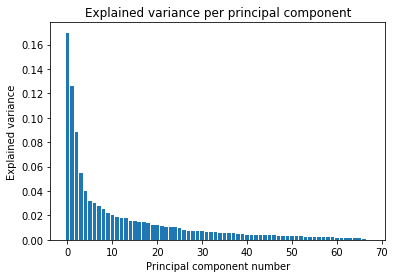

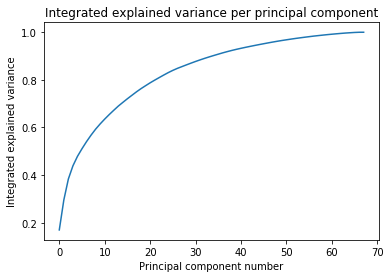

In [43]:
# Investigate the variance accounted for by each principal component.

#
#                           According to the API, we can extract all the ratios of variances 
#            at one time.  So we could plot all of them.
#
#                           Trying a bar chart.  By trial and error, I figured out
#            what num_components has to be.  
#
num_components=np.arange(len(pca.explained_variance_ratio_))
actuals=pca.explained_variance_ratio_
plt.bar(num_components,actuals)
plt.xlabel("Principal component number")
plt.ylabel("Explained variance")
plt.title("Explained variance per principal component")
plt.show()

#
#                           Hey that worked!  I think we can plot 
#            cumulatives.  Maybe get a visible "knee"!  
#
integrated_distribution = np.cumsum(actuals)
plt.plot(num_components,integrated_distribution)
plt.xlabel("Principal component number")
plt.ylabel("Integrated explained variance")
plt.title("Integrated explained variance per principal component")
plt.show()



In [44]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_rd_40 = PCA(n_components=40)
out_PCA_rd_40 = pca_rd_40.fit_transform(new_scaled)


### Discussion 2.2: Perform Dimensionality Reduction

Jackpot right away with 50?  0.965287!  Try some smaller values and larger values.  See if that holds up. 

Okay, first try blew up with a traceback when I tried 80 components.  The complaint was n_components=80
must be less tha 69 "n_features" with svd_solver='full'.  

Trying again with svd_solver='auto'.  Still complains, still says svd_solver='full'.

Plot of integrated explained variance shows no visible "knee".  Extremely smooth.  Have I done something wrong? 

Okay, pending comments from reviewer--i.e., what, if anything, I have done wrong to get such a smooth integrated function of added variance per component, I am going with N=40.  That gives a computed 92.8%.  Do we still have to worry about overfitting here?  If so, it should show up with poor results for the actual customer test data.  

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [45]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def show_PCA_weights(df,pca,n):
    weights_df=pd.DataFrame(pca.components_,columns=list(df.columns)).iloc[n]
    weights_df.sort_values(ascending=False, inplace=True)
    return weights_df


In [46]:
show_PCA_weights(new_scaled,pca_rd_40,0)

PLZ8_ANTG3               0.224077
PLZ8_ANTG4               0.218345
PLZ8_BAUMAX              0.213684
WEALTH                   0.201137
ORTSGR_KLS9              0.197265
HH_EINKOMMEN_SCORE       0.197262
EWDICHTE                 0.195049
FINANZ_HAUSBAUER         0.164372
KBA05_ANTG4              0.153274
PLZ8_ANTG2               0.152396
ARBEIT                   0.141665
ANZ_HAUSHALTE_AKTIV      0.134691
KBA05_ANTG3              0.133999
RELAT_AB                 0.133604
FINANZ_SPARER            0.114576
MOVEMENTS                0.102919
SEMIO_PFLICHT            0.085690
SEMIO_REL                0.082651
SEMIO_RAT                0.069879
DECADES                  0.068950
REGIOTYP                 0.063269
SEMIO_TRADV              0.060973
SEMIO_MAT                0.059279
SEMIO_FAM                0.059183
W_KEIT_KIND_HH           0.056617
OST_WEST_KZ              0.053857
SEMIO_KULT               0.049795
FINANZ_UNAUFFAELLIGER    0.047792
SEMIO_KAEM               0.043592
FINANZ_ANLEGER

In [47]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
show_PCA_weights(new_scaled,pca_rd_40,1)


ALTERSKATEGORIE_GROB     0.272059
FINANZ_VORSORGER         0.244825
SEMIO_ERL                0.235341
SEMIO_LUST               0.190993
RETOURTYP_BK_S           0.164526
W_KEIT_KIND_HH           0.117180
SEMIO_KRIT               0.111445
SEMIO_KAEM               0.103077
FINANZ_HAUSBAUER         0.095224
FINANZ_MINIMALIST        0.094514
ANREDE_KZ                0.085050
WOHNDAUER_2008           0.067008
EWDICHTE                 0.066763
SEMIO_DOM                0.065513
ORTSGR_KLS9              0.065455
PLZ8_ANTG3               0.061666
PLZ8_ANTG4               0.058647
PLZ8_BAUMAX              0.056539
KBA05_ANTG4              0.050217
ARBEIT                   0.048383
RELAT_AB                 0.046839
WEALTH                   0.045619
ANZ_HAUSHALTE_AKTIV      0.044173
PLZ8_ANTG2               0.043050
HH_EINKOMMEN_SCORE       0.028554
KBA05_ANTG3              0.027959
VERS_TYP                 0.027490
ANZ_HH_TITEL             0.026273
LIFE_STAGE               0.018519
OST_WEST_KZ   

In [48]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
show_PCA_weights(new_scaled,pca_rd_40,2)



SEMIO_VERT               0.346129
SEMIO_SOZ                0.262908
SEMIO_FAM                0.249868
SEMIO_KULT               0.236395
FINANZ_MINIMALIST        0.160631
RETOURTYP_BK_S           0.105400
FINANZ_VORSORGER         0.099483
W_KEIT_KIND_HH           0.086245
ALTERSKATEGORIE_GROB     0.076880
SEMIO_REL                0.070152
SEMIO_LUST               0.063188
SEMIO_MAT                0.055982
GREEN_AVANTGARDE         0.054896
PLZ8_BAUMAX              0.044164
ORTSGR_KLS9              0.044123
EWDICHTE                 0.043161
PLZ8_ANTG4               0.040653
PLZ8_ANTG3               0.039740
WOHNDAUER_2008           0.034481
ARBEIT                   0.031732
RELAT_AB                 0.028878
PLZ8_ANTG2               0.026418
KBA05_ANTG4              0.023524
ANZ_HAUSHALTE_AKTIV      0.020698
WEALTH                   0.020409
OST_WEST_KZ              0.013713
ANZ_HH_TITEL             0.012208
ANZ_TITEL                0.010108
LP_LEBENSPHASE_FEIN      0.006639
KBA05_ANTG3   

### Discussion 2.3: Interpret Principal Components

Interpretation is as follows:

First principal component
High positive weights:

PLZ8_ANTG3               0.224077   (6-10 family houses in region)
PLZ8_ANTG4               0.218345   (10+ family houses in region)
PLZ8_BAUMAX              0.213684   (type of family dwelling in region)
WEALTH                   0.201137   (decomposed from CAMEO_INTL_2015)
ORTSGR_KLS9              0.197265   (size of community)
HH_EINKOMMEN_SCORE       0.197262   (estimated household net income)

High negative weights:

KONSUMNAEHE             -0.167310   (distance from building to PoS)
FINANZ_MINIMALIST       -0.200186   (low financial interest)
KBA05_GBZ               -0.211418   (number of buildings in the microcell)
KBA05_ANTG1             -0.216795   (number of 1-2 family houses in the microcell)
PLZ8_ANTG1              -0.224088   (number of 1-2 family houses in the region)
MOBI_REGIO              -0.236979   (movement patterns)

The first principal component appears to be focused on the number and type of buildings locally;
the density of families in the housing in the region (both positively for higher density AND negatively for lower density of families);  wealth and income, positively, and negatively with low financial interest;  and negatively with regional mobility.  All of these make sense--more families in denser housing equal more potential shoppers, while fewer equal fewer potential shoppers.  Higher wealth and income and low finanical interest also would seem to correlate to more potential shoppers.  (Note that I'm assuming that "low financial interest" equals what Americans would call "lack of interest in saving".)  Regional mobility having a negative correlation makes sense, too:  higher mobility would cause less interest in shopping in this region.  

Note that almost all of these, except for wealth, income, and low financial interest, are not concerned with individuals.    

Second principal component

High positive weights:

ALTERSKATEGORIE_GROB     0.272059   (estimated age based on name)
FINANZ_VORSORGER         0.244825   (financial typology:  be prepared)
SEMIO_ERL                0.235341   (personality typology:  event-oriented)
SEMIO_LUST               0.190993   (personality typology:  sensual-minded)
RETOURTYP_BK_S           0.164526   (return type)
W_KEIT_KIND_HH           0.117180   (likelihood of children in the family)

High negative weights:

FINANZ_UNAUFFAELLIGER   -0.234287   (finincial typology:  inconspicious)
SEMIO_PFLICHT           -0.239714   (personality typology:  dutiful)
SEMIO_TRADV             -0.239726   (personality typology:  traditional-minded)
FINANZ_SPARER           -0.251934   (financial typology:  money-saver)
DECADES                 -0.262086   (decomposed from PRAEGENDE_JUGENDJAHRE, decade of youth)
SEMIO_REL               -0.264544   (personality typology:  religious)

The second principal component appears to be focused on persaonal characteristics.  Positive correlations with age, a tendency to be prepared, being focused on daily events while being focused on snsuality.  A positive correlation to return type doesn't seem to fit, but a correlation to number of children in the family would.
Negative correlation to money-saver would seem to fit, and if we assume a relgious peronality would be less interested in external possesions, that negative correlation would fit too.  

Third principal component

High positive weights:

SEMIO_VERT               0.346129   (Personality typology:  dreamful)
SEMIO_SOZ                0.262908   (Personality typology:  socially-minded)
SEMIO_FAM                0.249868   (Personality typology:  family-minded)
SEMIO_KULT               0.236395   (Personality typology:  culurally-minded)
FINANZ_MINIMALIST        0.160631   (Low financial interest)
RETOURTYP_BK_S           0.105400   (Return type)

High negative weights:

FINANZ_ANLEGER          -0.188625   (Financiqal typology:  investor)
SEMIO_RAT               -0.216057   (Personality typology:  rational)
SEMIO_KRIT              -0.277727   (Personality typology:  citical-minded)
SEMIO_DOM               -0.313125   (Personality typology:  dominant-minded)
SEMIO_KAEM              -0.337799   (Personality typology:  combative attitude)
ANREDE_KZ               -0.368812   (Gender)

The third principal component is again focused on personal characteristics.  Postive correlations with a "dreamful"  personality type--possibly someone who is focused on dreams of the future?;  with an outside-focused personality (social and family minded.  Again, low financial interest and return type show up.  Negatively correlated are a financial type of investor, a rational and critical mindset, a combative attitude.  This makes sense in that the shopper would be positively correlated with outside focus, negatively correlated with a critical and rational mindest, and would not be combative.  

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [49]:
# Over a number of different cluster counts...
with active_session():
    num_clusters=np.arange(10,23)
    scores=[]
    for k in num_clusters:
        print("Runnning for ",k)
        kmeans = KMeans(n_clusters=k)
        model = kmeans.fit(out_PCA_rd_40)
    # compute the average within-cluster distances.
        score = np.abs(model.score(out_PCA_rd_40))
        print("\tScore for ",k, "= ", score)
        scores.append(score)

    
    

Runnning for  10
	Score for  10 =  32664098.04
Runnning for  11
	Score for  11 =  32116465.6957
Runnning for  12
	Score for  12 =  31579048.3347
Runnning for  13
	Score for  13 =  31119885.7942
Runnning for  14
	Score for  14 =  30516189.9822
Runnning for  15
	Score for  15 =  30110494.7601
Runnning for  16
	Score for  16 =  29827052.3849
Runnning for  17
	Score for  17 =  29547144.9846
Runnning for  18
	Score for  18 =  28951424.6906
Runnning for  19
	Score for  19 =  28948572.4553
Runnning for  20
	Score for  20 =  28676397.4577
Runnning for  21
	Score for  21 =  28082829.0056
Runnning for  22
	Score for  22 =  27850046.2997


In [50]:
num_clusters

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

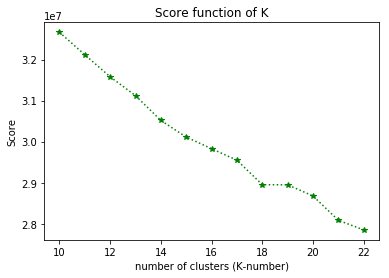

In [51]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(num_clusters,scores,marker='*',color='g',linestyle='dotted')
plt.xlabel('number of clusters (K-number)')
plt.ylabel('Score')
plt.title("Score function of K")
plt.show()


In [52]:
#
#               Show first and second finite differences.
#
diff1 = [0] * len(scores)
diff2 = [0] * len(scores)
#
#
for i in range(len(scores)-1):
    if ( i <= len(scores)-1):
        diff1[i] = (scores[i+1] - scores[i])
    if ( i < len(scores)-2): 
        diff2[i] = (scores[i+2] - 2.0 * scores[i+1] + scores[i])

print("First differences\n",80 * "-")
for j in range(len(scores)):
    print("Index ",j,diff1[j])
print("Second differences\n",80 * "-")
#
#                         Add one to the index, as delta^2 score[0]
#        is really shifted by one.
#
for j in range(len(scores)):
    print("Index ",j,diff2[j])

First differences
 --------------------------------------------------------------------------------
Index  0 -547632.34421
Index  1 -537417.361041
Index  2 -459162.5405
Index  3 -603695.811979
Index  4 -405695.222096
Index  5 -283442.375232
Index  6 -279907.400346
Index  7 -595720.293966
Index  8 -2852.23525233
Index  9 -272174.997586
Index  10 -593568.452108
Index  11 -232782.705901
Index  12 0
Second differences
 --------------------------------------------------------------------------------
Index  0 10214.9831691
Index  1 78254.8205407
Index  2 -144533.271478
Index  3 198000.589882
Index  4 122252.846864
Index  5 3534.97488607
Index  6 -315812.89362
Index  7 592868.058713
Index  8 -269322.762334
Index  9 -321393.454522
Index  10 360785.746207
Index  11 0
Index  12 0


In [53]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=18)
model=kmeans.fit(out_PCA_rd_40)
data_pred=model.predict(out_PCA_rd_40)


### Discussion 3.1: Apply Clustering to General Population
Looking at the plot, and even more at the first and second finite differences of the scores, there is not a huge change anywhere along the path between 10 clusters and 22 clusters.  The change in score per new added cluster is really pretty modest:  for example, at 22 clusters, the score has declined, but only to 85.26% of what it was with 10 clusters.   There is a change in the behavior of the scores at k=18.  (Note that the second difference is effectively shifted one lower than the actual, just because of Python's list indexing property.)  Therefore the big bounce downward visually at k=18, the positive change of the first difference at k=18, is matched by the second difference change.  Therefore, we will segment the data into 18 clusters, as this seems as good a choice as any other. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [54]:
# Load in the customer demographics data.
customers =  pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [55]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned_up = clean_data(customers)
#
#                   Copied my own code from above.
#
cust_copy=customers_cleaned_up.copy()
column_list = cust_copy.columns
imputer = Imputer(strategy='median', axis=0)
cust_copy = imputer.fit_transform(cust_copy)
cust_copy = pd.DataFrame(cust_copy, columns= column_list)

#feature transformation
customers_scaled=scaler.fit_transform(cust_copy)
customers_scaled=pd.DataFrame(customers_scaled,columns=column_list)
customers_pca=pca_rd_40.transform(customers_scaled)
predict_customers = model.predict(customers_pca)


(191652, 79)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_lau

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [61]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

clus_predicted_gen_pop = pd.Series(data_pred).value_counts().sort_index()
sum_of_data = pd.Series(data_pred).sum()
clus_predicted_gen_pop

0     48958
1     45801
2     66465
3     53373
4     49018
5     40398
6     42121
7     52310
8     61992
9     54583
10    40801
11    39784
12    25731
13    22110
14    45336
15    52199
16    50370
17     6717
dtype: int64

In [62]:
print("Sum = ",sum_of_data)

Sum =  6122625


In [76]:
gen_percent = []
clus_pred_gen_pop=clus_predicted_gen_pop.values.tolist()
for i in range(len(clus_pred_gen_pop)):
    prop = clus_pred_gen_pop[i]/sum_of_data
    gen_percent.append(prop*100.0)
gen_percent    

[0.79962434413343941,
 0.7480614932320695,
 1.0855637900410364,
 0.87173393764929263,
 0.80060431595924941,
 0.65981503031787836,
 0.68795655458238913,
 0.85437210346869186,
 1.0125068904269003,
 0.89149670280312776,
 0.66639717441456892,
 0.64978665196708929,
 0.42026091749862193,
 0.36111961781098795,
 0.74046671158204203,
 0.85255915559094342,
 0.82268634776750171,
 0.10970784589943039]

In [72]:
# no of predictions of persons in each cluster in the customers data 
clus_predicted_customers = pd.Series(predict_customers).value_counts().sort_index()
sum_of_cust_data = pd.Series(predict_customers).sum()
clus_predicted_customers

0      3653
1      6019
2     19828
3      3311
4     20736
5      7213
6      8056
7      7150
8      7410
9      6844
10     5020
11     9414
12     7297
13     3772
14     7410
15    14069
16     3132
17     1391
dtype: int64

In [73]:
print("Sum_of_cust = ",sum_of_cust_data)

Sum_of_cust =  1072767


In [78]:
cust_percent = []
clus_pred_customers=clus_predicted_customers.values.tolist()
for i in range(len(clus_pred_customers)):
    prop = clus_pred_customers[i]/sum_of_cust_data
    cust_percent.append(prop*100.0)
cust_percent  

[0.34052128747435373,
 0.56107244163923764,
 1.8483044314375814,
 0.30864111218931978,
 1.9329453646504786,
 0.67237340447646132,
 0.75095524004746605,
 0.66650074060816555,
 0.69073713117573521,
 0.63797637324787215,
 0.46794877172769112,
 0.87754377231961844,
 0.68020362296752235,
 0.35161409700335672,
 0.69073713117573521,
 1.3114683803659135,
 0.291955289452416,
 0.12966468953649765]

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

We need to adjust to the faxct that there are more people in the general population data than in the customer data.  So we compute a proportion.  
(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.